In [1]:
import os, sys, json
import pandas as pd
import geopandas as gpd
from shapely import geometry

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/miniconda3/envs/ffsc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:

colors = {
    'coal_mines':           '#89163e',
    'oil_fields':           '#001c49',
    'well_pads':            '#6c0093',
    'processing_plants':    '#be46a6',
    'refineries':           '#be46a6',
    'ports':                '#7f5636',
    'lng':                  '#46beb1',
    'shipping':             '#7f5636',
    'pipelines':            '#006400',
    'railways':             '#646464',
    'cities':               '#96C3E4',
    'power_stations':       '#8ac27e',
}

In [3]:
all_data_dirs = {
            'cities-N':              os.path.join('.','..','results_backup','simplify','cities_nodes_dataframe.csv'),
            'pipelines-cities':      os.path.join('.','..','results_backup','simplify','cities_pipelines_edge_dataframe.csv'),
            'ports-cities':          os.path.join('.','..','results_backup','output','cities_ports_edge_dataframe.csv'),
            'railways-cities':       os.path.join('.','..','results_backup','simplify','cities_railways_edge_dataframe.csv'),
            'coalmines-railways':    os.path.join('.','..','results_backup','simplify','coal_mine_railway_edge_dataframe.csv'),
            'coalmines-N':           os.path.join('.','..','results_backup','output','coal_mines_nodes_dataframe.csv'),
            'lng-N':                 os.path.join('.','..','results_backup','output','lng_nodes_dataframe.csv',  ),
            'lng-pipelines':         os.path.join('.','..','results_backup','simplify','lng_pipeline_edge_dataframe.csv'),
            'lng-shipping':          os.path.join('.','..','results_backup','output','lng_shipping_route_edge_dataframe.csv'),
            'oilfields-pipelines':   os.path.join('.','..','results_backup','simplify','oil_field_edge_dataframe.csv'),
            'oilfields-N':           os.path.join('.','..','results_backup','oil_field_nodes_fixup.csv'),
            'pipelines-pipelines':   os.path.join('.','..','results_backup','simplify','pipeline_edge_dataframe.csv'),
            'pipelines-N':           os.path.join('.','..','results_backup','simplify','pipeline_node_dataframe.csv'),
            'ports-N':               os.path.join('.','..','results_backup','output','port_node_dataframe.csv',  ),
            'ports-pipelines':       os.path.join('.','..','results_backup','simplify','port_pipeline_edge_dataframe.csv'),
            'ports-shipping':        os.path.join('.','..','results_backup','output','port_ship_edge_dataframe.csv'),
            'ports-railways':        os.path.join('.','..','results_backup','simplify','port_railway_edge_dataframe.csv'),
            'powerstn-N':            os.path.join('.','..','results_backup','output','power_station_nodes_dataframe.csv'),
            'powerstn-pipelines':    os.path.join('.','..','results_backup','simplify','power_station_pipeline_edge_dataframe.csv'),
            'powerstn-railways':     os.path.join('.','..','results_backup','simplify','power_station_railway_edge_dataframe.csv'),
            'procplant-N':           os.path.join('.','..','results_backup','output','processing_plant_nodes_dataframe.csv'),
            'procplant-pipelines':   os.path.join('.','..','results_backup','simplify','processing_plant_pipeline_edge_dataframe.csv'),
            'railways-railways':     os.path.join('.','..','results_backup','simplify','railway_edge_dataframe.csv'),
            'railways-N':            os.path.join('.','..','results_backup','simplify','railway_nodes_dataframe.csv'),
            'refineries-N':          os.path.join('.','..','results_backup','output','refinery_nodes_dataframe.csv'),
            'refineries-pipelines':  os.path.join('.','..','results_backup','simplify','refinery_pipeline_edge_dataframe.csv'),
            'shipping-shipping':     os.path.join('.','..','results_backup','output','shipping_edge_dataframe.csv'),
            'shipping-N':            os.path.join('.','..','results_backup','output','shipping_node_dataframe.csv'),
            'wellpads-N':            os.path.join('.','..','results_backup','output','well_pad_nodes_dataframe.csv'),
            'wellpads-pipelines':    os.path.join('.','..','results_backup','simplify','well_pad_pipeline_edge_dataframe.csv'),
        }

In [4]:
ne = gpd.read_file('./../data/ne/ne_10m_countries.gpkg')

In [10]:
def check_edges(edge_code, node_code, edgenode_code, side):
    edgenode_df = pd.read_csv(all_data_dirs[edgenode_code])
    edge_df = pd.read_csv(all_data_dirs[edge_code])
    node_df = pd.read_csv(all_data_dirs[node_code])
    
    # fix coords
    edge_df['coordinates'] = edge_df['coordinates'].str.replace('(','[').str.replace(')',']')
    
    # join
    
    s_ID = [cc for cc in edgenode_df.columns if 'START_ID' in cc][0]
    t_ID = [cc for cc in edgenode_df.columns if 'END_ID' in cc][0]
    e_ID = [cc for cc in edge_df.columns if 'ID' in cc][0]
    n_ID = [cc for cc in node_df.columns if 'ID' in cc][0]
    
    if side=='L': # network asset is the start
       
        edgenode_df = edgenode_df.merge(edge_df[[e_ID,'coordinates']], how='left', left_on=s_ID, right_on=e_ID)
        edgenode_df = edgenode_df.merge(node_df[[n_ID,'coordinates']], how='left', left_on=t_ID, right_on=n_ID)
        
    elif side=='R': # network asset is the end
        
        edgenode_df = edgenode_df.merge(node_df[[n_ID,'coordinates']], how='left', left_on=s_ID, right_on=n_ID)
        edgenode_df = edgenode_df.merge(edge_df[[e_ID,'coordinates']], how='left', left_on=t_ID, right_on=e_ID)
        

    edgenode_df = edgenode_df.rename(columns={'coordinates_x':'start_coordinates', 'coordinates_y':'end_coordinates'})
    
    print (edgenode_df)
    for cc in ['start_coordinates', 'end_coordinates']:
        edgenode_df[cc]=edgenode_df[cc].apply(json.loads)
    edgenode_df['geometry'] = edgenode_df[['start_coordinates', 'end_coordinates']].values.tolist()
    edgenode_df['geometry'] = edgenode_df['geometry'].apply(geometry.LineString)
    edgenode_gdf = gpd.GeoDataFrame(edgenode_df, geometry=edgenode_df['geometry'], crs={'init':'epsg:4326'})
    
    # plot
    fig, ax = plt.subplots(1,1,figsize=(40,20))
    ne.plot(ax=ax, color='#e3e3e3')
    edgenode_gdf.plot(ax=ax, color='r', alpha=0.2)
    plt.show()

       Unnamed: 0   distance   impedance  \
0          316008   1.813155    3.287533   
1         1403900   2.574878    6.629998   
2         1558684   4.329523   18.744772   
3         1558990   5.936394   35.240772   
4         1559418  10.121379  102.442311   
...           ...        ...         ...   
10503     1551039   0.486058    0.236252   
10504     1087385   0.655929    0.430243   
10505     1087959   3.295278   10.858858   
10506     1557662  10.298343  106.055878   
10507     1557763   2.996275    8.977662   

      PowerStationID:START_ID(PowerStation)  \
0                        power_station_1000   
1                       power_station_10000   
2                       power_station_10002   
3                       power_station_10003   
4                       power_station_10006   
...                                     ...   
10503                    power_station_9991   
10504                    power_station_9996   
10505                    power_station_9997   
1

/home/ubuntu/miniconda3/envs/ffsc/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


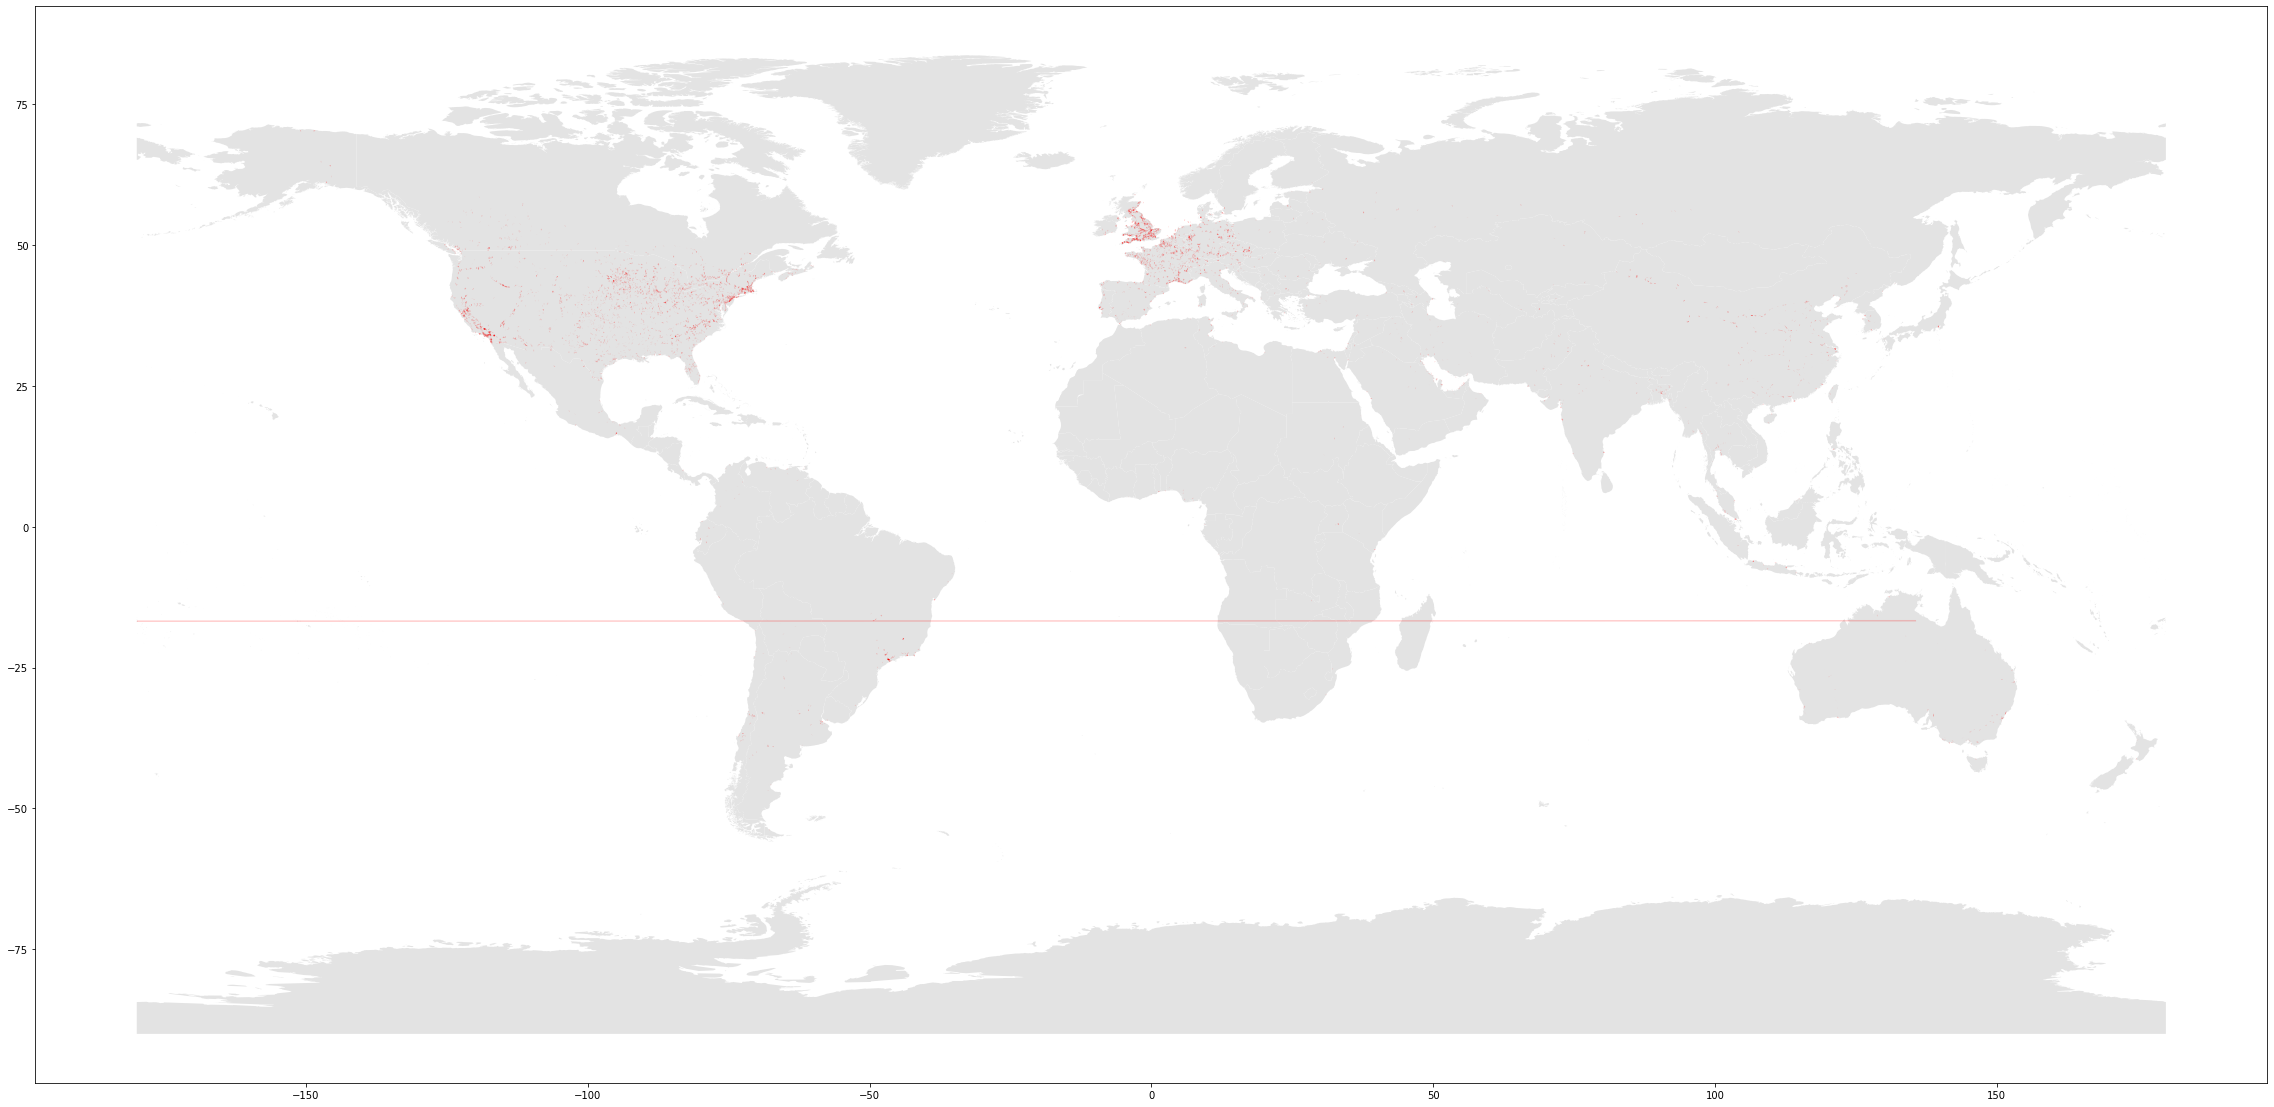

In [16]:
check_edges('pipelines-N','powerstn-N','powerstn-pipelines','R')